<a href="https://colab.research.google.com/github/jblanco89/MonteCarlo_Portfolio/blob/main/portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import pandas_datareader.data as pdr
import numpy as np
import matplotlib.pyplot as plt
import time


In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

Tickers for Portfolio

In [ ]:
stocks = ['ETH-USD', 'LTC-USD','BNB-USD', 'ADA-USD', 'SOL1-USD', 
          'AVAX-USD', 'DASH-USD'] 

In [ ]:
#data from tickers

def get_data(tickers, date_beg, date_end):
  df = pdr.get_data_yahoo(stocks, start=date_beg, end=date_end)['Adj Close']
  df.sort_index(inplace=True)
  return df

In [ ]:
prices = get_data(stocks, '01/01/2021', '09/18/2021')
print(prices.tail())

Symbols         ETH-USD     LTC-USD  ...   AVAX-USD    DASH-USD
Date                                 ...                       
2021-09-13  3429.169678  183.139069  ...  51.578117  205.419998
2021-09-14  3615.282715  189.239410  ...  57.625393  208.896652
2021-09-15  3571.294922  185.538071  ...  67.842697  208.368179
2021-09-16  3398.538818  179.684082  ...  69.934013  198.482162
2021-09-19  3360.402100  178.155716  ...  72.865288  196.849731

[5 rows x 7 columns]


In [ ]:
#Calculating daily return 
def daily_returns(df):
    return (df.pct_change())

daily_rets = daily_returns(prices)

print(daily_rets.tail())



Symbols      ETH-USD   LTC-USD   BNB-USD  ...  SOL1-USD  AVAX-USD  DASH-USD
Date                                      ...                              
2021-09-13  0.043725  0.020365  0.038021  ... -0.066017 -0.028846  0.045301
2021-09-14  0.054273  0.033310  0.041490  ...  0.006468  0.117245  0.016925
2021-09-15 -0.012167 -0.019559 -0.015701  ... -0.041751  0.177306 -0.002530
2021-09-16 -0.048374 -0.031551 -0.042427  ... -0.032012  0.030826 -0.047445
2021-09-19 -0.011222 -0.008506  0.012911  ...  0.094014  0.041915 -0.008225

[5 rows x 7 columns]


In [ ]:
#Setting function for calculting daily return for every selected coin

def mean_return(daily_returns):
    return (daily_returns.mean())

mean_return_rets = mean_return(daily_rets)
print(mean_return_rets.tail())


Symbols
BNB-USD     0.012734
ADA-USD     0.012799
SOL1-USD    0.021587
AVAX-USD    0.016861
DASH-USD    0.006428
dtype: float64


In [ ]:
#creating covariance matrices

def covariance_matrix(daily_returns):
    return (daily_returns.cov())

cov_matrix_all = covariance_matrix(daily_rets)
print(cov_matrix_all)

Symbols    ETH-USD   LTC-USD   BNB-USD   ADA-USD  SOL1-USD  AVAX-USD  DASH-USD
Symbols                                                                       
ETH-USD   0.003741  0.003213  0.003068  0.002776  0.002609  0.002973  0.003168
LTC-USD   0.003213  0.004264  0.003398  0.002962  0.002231  0.003193  0.004055
BNB-USD   0.003068  0.003398  0.007695  0.003171  0.003754  0.004327  0.003987
ADA-USD   0.002776  0.002962  0.003171  0.005720  0.002276  0.004935  0.002923
SOL1-USD  0.002609  0.002231  0.003754  0.002276  0.008632  0.003771  0.002579
AVAX-USD  0.002973  0.003193  0.004327  0.004935  0.003771  0.011596  0.003568
DASH-USD  0.003168  0.004055  0.003987  0.002923  0.002579  0.003568  0.006955


In [ ]:
# ------------------------------------------------------
# ------ MONTECARLO SIMULATION FUNCTION ----------------
# ------------------------------------------------------

#we must create a function to calculate returns, standard dev 
# and Sharpe ratios for speciefied randomly weighted portfolios

def results_dataframe(tickers, number_portfolios, mean_daily_returns, cov_matrix):
    results_temp = np.zeros((4 + len(tickers) - 1, number_portfolios))

    for i in range(number_portfolios):
        # select random weights for portfolio holdings
        weights = np.array(np.random.random(len(tickers)))
        
        # rebalance weights to sum to 1
        weights /= np.sum(weights)

        # calculate portfolio return and volatility
        portfolio_return = np.sum(mean_daily_returns * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

        # 3 month T-Bill yield used as risk free rate of return
        risk_free_return = 0.0139

        # store results in results array
        results_temp[0, i] = portfolio_return
        results_temp[1, i] = portfolio_std_dev
        
        # store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
        results_temp[2, i] = (results_temp[0, i] - risk_free_return) / results_temp[1, i]
        
        # iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_temp[j + 3, i] = weights[j]

    # convert results array to Pandas DataFrame
    results_df = pd.DataFrame(results_temp.T, columns=['ret', 'stdev', 'sharpe', tickers[0], 
                                                       tickers[1], tickers[2],
                                                       tickers[3], tickers[4],
                                                       tickers[5],tickers[6]])
    
    return results_df



In [ ]:
results_crypto = results_dataframe(stocks,20000, mean_return_rets, cov_matrix_all)
print(results_crypto.tail())

            ret     stdev    sharpe  ...  SOL1-USD  AVAX-USD  DASH-USD
19995  2.590881  0.945310  2.726069  ...  0.143215  0.002545  0.248185
19996  2.605639  0.980005  2.644619  ...  0.241312  0.019644  0.274827
19997  3.392640  1.054802  3.203199  ...  0.302037  0.212349  0.261060
19998  2.242943  0.945412  2.357748  ...  0.073854  0.012162  0.236012
19999  2.765539  0.969078  2.839441  ...  0.196756  0.050741  0.122321

[5 rows x 10 columns]


In [ ]:
#finding portfolio with the highest sharpe ratio

def max_sr(results_df):
    return results_df.iloc[results_df['sharpe'].idxmax()]

max_sharpe_portfolio = max_sr(results_crypto)
print(max_sharpe_portfolio)


ret         4.214284
stdev       1.077555
sharpe      3.898069
ETH-USD     0.085906
LTC-USD     0.007733
BNB-USD     0.047179
ADA-USD     0.236587
SOL1-USD    0.447877
AVAX-USD    0.154228
DASH-USD    0.020490
Name: 3676, dtype: float64


In [ ]:
#identifiying portfolio with the lowest volatility (stdev)

def min_vol(result_df):
    return result_df.iloc[result_df['stdev'].idxmin()]


In [ ]:
min_vol_portfolio = min_vol(result_df=results_crypto)
print(min_vol_portfolio)

ret         2.280948
stdev       0.915098
sharpe      2.477383
ETH-USD     0.357674
LTC-USD     0.278453
BNB-USD     0.004004
ADA-USD     0.218825
SOL1-USD    0.092804
AVAX-USD    0.012222
DASH-USD    0.036018
Name: 13314, dtype: float64


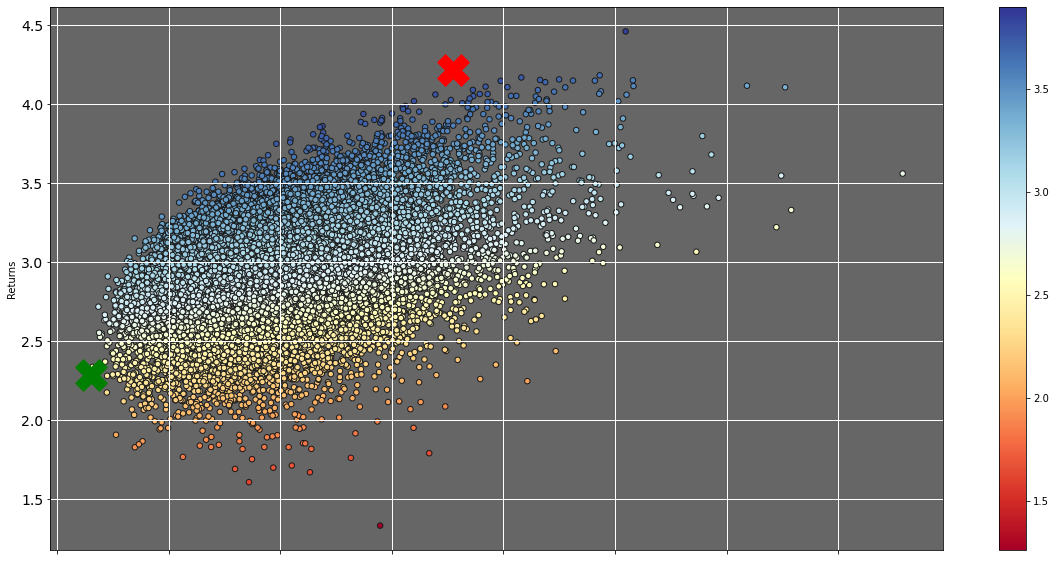

In [ ]:
#Plot all different portfolio results with different weights

def plot_graph(results_df, max_sharpe_port, min_vol_port):
    ax = results_df.plot(kind= 'scatter', x = 'stdev', y='ret', s = 30, 
                         c=results_df.sharpe, cmap='RdYlBu',edgecolors='.1', figsize=(20,10))
    ax.grid(False, color='w', linestyle='-', linewidth=1)
    ax.set_facecolor('0.4')
    ax.set_xlabel('Volatility')
    ax.set_ylabel('Returns')
    ax.tick_params(labelsize = 14)

    # # plot red star to highlight position of portfolio with highest Sharpe Ratio
    ax.scatter(max_sharpe_port[1], max_sharpe_port[0], marker="X", color='r', s=1000)
    # # plot green star to highlight position of minimum variance portfolio
    ax.scatter(min_vol_port[1], min_vol_port[0], marker="X", color='g', s=1000)

plot_graph(results_crypto,max_sharpe_portfolio, min_vol_portfolio)
plt.show()

In [ ]:
#Looking for real portfolio weight
real_portfolio = [0.30, 0.05, 0.05, 0.20, 0.10, 0.15, 0.15]
type(real_portfolio)

list

In [ ]:
rf = results_crypto.iloc[:,[3,4,5,6,7,8,9]]
rf

,ETH-USD,LTC-USD,BNB-USD,ADA-USD,SOL1-USD,AVAX-USD,DASH-USD
0,0.048287,0.255950,0.080104,0.135930,0.082633,0.119743,0.277354
1,0.002870,0.284344,0.185799,0.094676,0.180798,0.108052,0.143461
2,0.023669,0.106591,0.106206,0.248161,0.138327,0.139094,0.237953
3,0.133670,0.197446,0.054576,0.206851,0.056719,0.152629,0.198110
4,0.206136,0.138102,0.159561,0.050224,0.062792,0.196336,0.186849
...,...,...,...,...,...,...,...
19995,0.191014,0.134021,0.011599,0.269421,0.143215,0.002545,0.248185
19996,0.111005,0.253059,0.060218,0.039936,0.241312,0.019644,0.274827
19997,0.038330,0.107117,0.058591,0.020514,0.302037,0.212349,0.261060
19998,0.236799,0.204708,0.040706,0.195758,0.073854,0.012162,0.236012


In [ ]:
rf_round = np.round(rf,decimals=2)
rf_round

,ETH-USD,LTC-USD,BNB-USD,ADA-USD,SOL1-USD,AVAX-USD,DASH-USD
0,0.05,0.26,0.08,0.14,0.08,0.12,0.28
1,0.00,0.28,0.19,0.09,0.18,0.11,0.14
2,0.02,0.11,0.11,0.25,0.14,0.14,0.24
3,0.13,0.20,0.05,0.21,0.06,0.15,0.20
4,0.21,0.14,0.16,0.05,0.06,0.20,0.19
...,...,...,...,...,...,...,...
19995,0.19,0.13,0.01,0.27,0.14,0.00,0.25
19996,0.11,0.25,0.06,0.04,0.24,0.02,0.27
19997,0.04,0.11,0.06,0.02,0.30,0.21,0.26
19998,0.24,0.20,0.04,0.20,0.07,0.01,0.24


In [ ]:
rf_round.isin(real_portfolio).any()

ETH-USD     True
LTC-USD     True
BNB-USD     True
ADA-USD     True
SOL1-USD    True
AVAX-USD    True
DASH-USD    True
dtype: bool

In [ ]:

weights = real_portfolio
results_temp = np.zeros((4 + len(stocks) - 1, 1))    
# rebalance weights to sum to 1
weights /= np.sum(weights)

# calculate portfolio return and volatility
portfolio_return = np.sum(mean_return_rets * weights) * 252
portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_all, weights))) * np.sqrt(252)

# 3 month T-Bill yield used as risk free rate of return
risk_free_return = 0.0139

# store results in results array
results_temp[0, 0] = portfolio_return
results_temp[1, 0] = portfolio_std_dev
    
# store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
results_temp[2, 0] = (results_temp[0, 0] - risk_free_return) / results_temp[1, 0]
    
# iterate through the weight vector and add data to results array
for j in range(len(weights)):
  results_temp[j + 3, 0] = weights[j]

# convert results array to Pandas DataFrame
results_test_portfolio = pd.DataFrame(results_temp.T, columns=['ret', 'stdev', 'sharpe', stocks[0], 
                                                    stocks[1], stocks[2],
                                                    stocks[3], stocks[4],
                                                    stocks[5],stocks[6]])

results_test_portfolio


,ret,stdev,sharpe,ETH-USD,LTC-USD,BNB-USD,ADA-USD,SOL1-USD,AVAX-USD,DASH-USD
0,2.860933,0.962521,2.957893,0.3,0.05,0.05,0.2,0.1,0.15,0.15


In [ ]:
def plot_graph_test(results_df, max_sharpe_port, min_vol_port, results_test):
    ax = results_df.plot(kind= 'scatter', x = 'stdev', y='ret', s = 40, 
                         c=results_df.sharpe, cmap='RdYlBu',edgecolors='.1', 
                         figsize=(20,10))
    ax.grid(False, color='w', linestyle='-', linewidth=1)
    ax.set_facecolor('0.4')
    ax.set_title("MonteCarlo simulation with real portfolio", fontsize=22, 
                 fontweight='bold')
    ax.set_xlabel('Volatility', fontsize = 14)
    ax.set_ylabel('Returns', fontsize = 14)
    ax.tick_params(labelsize = 14) 

    # # plot red star to highlight position of portfolio with highest Sharpe Ratio
    ax.scatter(max_sharpe_port[1], max_sharpe_port[0], marker="X", color='darkred', s=700)
    # # plot green star to highlight position of minimum variance portfolio
    ax.scatter(min_vol_port[1], min_vol_port[0], marker="X", color='b', s=700)

    rt = results_test.values

    ax.scatter(rt[0,1], rt[0,0], marker = "X", color = 'k', s=700)




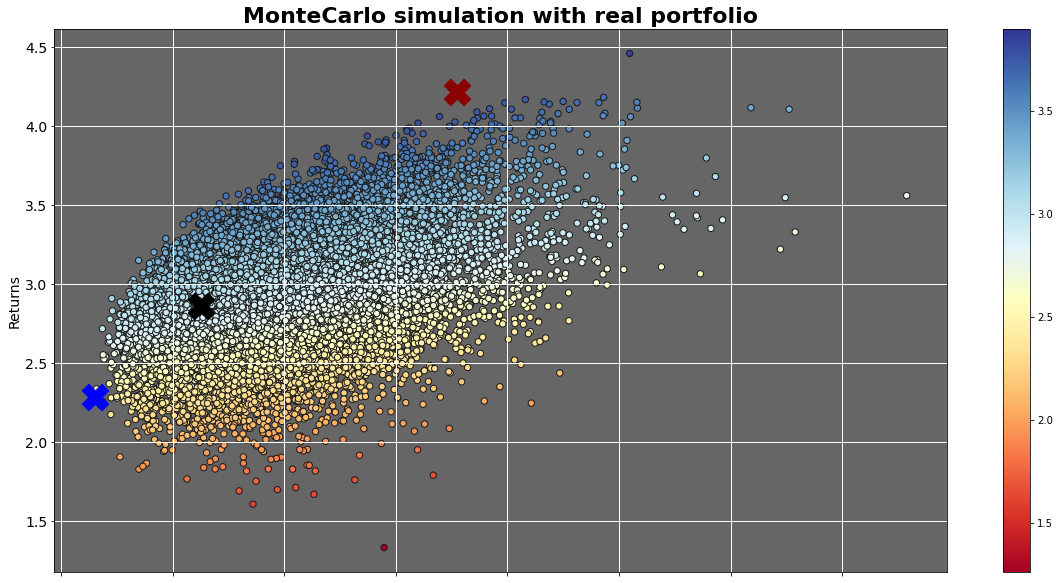

In [ ]:
plot_graph_test(results_crypto, max_sharpe_portfolio, min_vol_portfolio, results_test_portfolio)
plt.show()

In [ ]:
%%shell
jupyter nbconvert --to html /content/portfolio.ipynb


[NbConvertApp] Converting notebook /content/portfolio.ipynb to html
[NbConvertApp] Writing 1224186 bytes to /content/portfolio.html
